In [ ]:
# !pip install fasttext

In [ ]:
# !pip install gensim

In [51]:
!pip install sastrawi

In [52]:
from datasets import load_dataset
import re, time, torch, torch.nn as nn
import pandas as pd
import string
import nltk
from nltk.tokenize import word_tokenize
import torch
from torch.utils.data import DataLoader, TensorDataset, Dataset
from transformers import AutoTokenizer, AutoModel, BertTokenizer, BertModel
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.optim import AdamW
import numpy as np
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sentence_transformers import SentenceTransformer
from sklearn.svm import SVC
import seaborn as sns

In [53]:
#prerocessing
from collections import OrderedDict

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from datetime import datetime

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load Data

source : https://huggingface.co/datasets/indonlp/NusaX-senti

In [54]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
#Nilam
path = "/content/drive/MyDrive/MKA/semester 2/PMML/Before UTS/Tugas Kelompok PMML/Backup-data/"

In [56]:
#atika
path = "/content/drive/MyDrive/coba/"

In [57]:
#ss
path ="/content/drive/MyDrive/Smt2/PMML/Tugas Kelompok PMML/Backup-data/"

In [58]:
data_full = pd.read_excel(path + "Komentar Tiktok IKN Data.xlsx")

In [59]:
data_full.head()

,text,label
0,ikn ibukota koruptor nepotisme,negatif
1,sy mau tanya ikn itu untuk apa trs yg menempat...,negatif
2,bapak skolahin anak nya yg setinggi nnti bsa n...,negatif
3,wacana belim ada kesitu realnya dan faktanya a...,negatif
4,follow ig ikn pak udh dr lama kq buka lowongan...,negatif


In [60]:
print(data_full['label'].value_counts())

label
negatif    780
positif    692
Name: count, dtype: int64


# Stemming + stop word

In [63]:
#steaming
start_time = datetime.now()

factory = StemmerFactory()
stemmer = factory.create_stemmer()

data_full['text_clean_steam'] = data_full['text'].apply(lambda x: stemmer.stem(x))
data_full.head()

end_time = datetime.now()
print('Waktu yang diperlukan: {}'.format(end_time - start_time))

Waktu yang diperlukan: 0:04:35.047878


In [64]:
#stopword
factory = StopWordRemoverFactory()
list_stopword = factory.get_stop_words()
len(list_stopword)

126

In [65]:
#stopword
factory = StopWordRemoverFactory()
stopword = factory.create_stop_word_remover()

data_full['text_stp_sastrawi'] = data_full['text_clean_steam'].apply(lambda x: " ".join(stopword.remove(x) for x in x.split() ))
data_full.head()

,text,label,text_clean_steam,text_stp_sastrawi
0,ikn ibukota koruptor nepotisme,negatif,ikn ibukota koruptor nepotisme,ikn ibukota koruptor nepotisme
1,sy mau tanya ikn itu untuk apa trs yg menempat...,negatif,sy mau tanya ikn itu untuk apa trs yg tempat i...,sy mau tanya ikn apa trs yg tempat ikn rakya...
2,bapak skolahin anak nya yg setinggi nnti bsa n...,negatif,bapak skolahin anak nya yg setinggi nnti bsa n...,bapak skolahin anak nya yg setinggi nnti bsa n...
3,wacana belim ada kesitu realnya dan faktanya a...,negatif,wacana belim ada kesitu real dan fakta aja jan...,wacana belim kesitu real fakta aja jangan ng...
4,follow ig ikn pak udh dr lama kq buka lowongan...,negatif,follow ig ikn pak udh dr lama kq buka lowong t...,follow ig ikn pak udh dr lama kq buka lowong t...


# Split data

In [66]:
from sklearn.model_selection import train_test_split

X = data_full["text_clean_steam"]
y = data_full["label"]

# Split pertama: Train (70%) + Temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Split kedua: Validation (15%) + Test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Train:", len(X_train))
print("Validation:", len(X_val))
print("Test:", len(X_test))


Train: 1030
Validation: 221
Test: 221


In [67]:
df_train = pd.DataFrame({"text": X_train, "label": y_train})
df_val   = pd.DataFrame({"text": X_val, "label": y_val})
df_test  = pd.DataFrame({"text": X_test, "label": y_test})


# MLP + Indobert 2

In [68]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [69]:
model_name = "indolem/indobertweet-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
indobert = AutoModel.from_pretrained(model_name).to(device)
indobert.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(31923, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [70]:
def bert_encode(texts, tokenizer, model, device, max_len=128, batch_size=32):
    embeddings = []
    loader = DataLoader(texts, batch_size=batch_size, shuffle=False)
    with torch.no_grad():
        for batch_texts in loader:
            enc = tokenizer(
                list(batch_texts),
                truncation=True, padding="max_length",
                max_length=max_len, return_tensors="pt"
            )
            input_ids = enc["input_ids"].to(device)
            attention_mask = enc["attention_mask"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            seq_emb = outputs.last_hidden_state   # [batch, seq_len, 768]
            embeddings.append(seq_emb.cpu())
    return torch.cat(embeddings, dim=0)

In [71]:
print("Encoding dataset with IndoBERT...")
X_train_bert = bert_encode(df_train["text"].tolist(), tokenizer, indobert, device)
X_val_bert   = bert_encode(df_val["text"].tolist(), tokenizer, indobert, device)
X_test_bert  = bert_encode(df_test["text"].tolist(), tokenizer, indobert, device)

Encoding dataset with IndoBERT...


In [72]:
from sklearn.preprocessing import LabelEncoder
import torch

# Buat encoder dan fit hanya dari data train
le = LabelEncoder()
le.fit(df_train["label"])

# Transform label ke angka
y_train_bert = torch.tensor(le.transform(df_train["label"]), dtype=torch.long)
y_val_bert   = torch.tensor(le.transform(df_val["label"]), dtype=torch.long)
y_test_bert  = torch.tensor(le.transform(df_test["label"]), dtype=torch.long)

# Cek mapping label → angka
print("Mapping label:", dict(zip(le.classes_, le.transform(le.classes_))))
print("Contoh y_train_bert:", y_train_bert[:10])

Mapping label: {'negatif': np.int64(0), 'positif': np.int64(1)}
Contoh y_train_bert: tensor([1, 0, 0, 1, 0, 1, 0, 1, 1, 0])


In [73]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim=768, hidden_size=64, num_labels=2, dropout=0.2):
        super(MLPClassifier, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_size),  # input: CLS embedding (768)
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, num_labels)  # output: kelas
        )

    def forward(self, cls_embedding):
        # cls_embedding = [batch, 768] dari hasil IndoBERT
        logits = self.mlp(cls_embedding)
        return logits

In [74]:
# Instantiate Model
model_bert = MLPClassifier(input_dim=768, hidden_size=64, num_labels=len(le.classes_)).to(device)

In [75]:
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model_bert.parameters()),
    lr=1e-5,
    weight_decay=1e-4
)
criterion = nn.CrossEntropyLoss()
batch_size = 16
epochs = 100  # Early Stopping akan berhenti lebih awal

train_losses, val_losses = [], []
train_accs, val_accs = [], []

# ===============================================
# Variabel Early Stopping berbasis Val Accuracy (tanpa min_delta)
# ===============================================
best_val_acc = 0.0        # akurasi validasi tertinggi
patience = 7             # berhenti kalau stagnan selama 10 epoch
patience_counter = 0
best_model_state = None
# ===============================================

for epoch in range(epochs):
    # ==========================
    # Training
    # ==========================
    model_bert.train()
    total_loss, correct, total = 0, 0, 0
    for i in range(0, len(X_train_bert), batch_size):
        x_batch = X_train_bert[i:i+batch_size].to(device)
        y_batch = y_train_bert[i:i+batch_size].to(device)

        optimizer.zero_grad()
        cls_emb = x_batch[:, 0, :]       # ambil CLS token
        outputs = model_bert(cls_emb)    # MLP prediksi
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predicted = torch.max(outputs, 1)[1]
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    avg_loss = total_loss / (len(X_train_bert) // batch_size)
    acc = correct / total

    # ==========================
    # Validation
    # ==========================
    model_bert.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for i in range(0, len(X_val_bert), batch_size):
            x_batch = X_val_bert[i:i+batch_size].to(device)
            y_batch = y_val_bert[i:i+batch_size].to(device)

            cls_emb = x_batch[:, 0, :]
            outputs = model_bert(cls_emb)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            predicted = torch.max(outputs, 1)[1]
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    avg_val_loss = val_loss / (len(X_val_bert) // batch_size)
    val_acc = correct / total

    train_losses.append(avg_loss)
    train_accs.append(acc)
    val_losses.append(avg_val_loss)
    val_accs.append(val_acc)

    # ==========================
    # Logika Early Stopping (tanpa min_delta)
    # ==========================
    is_best = ""
    if val_acc > best_val_acc:  # setiap kenaikan dianggap signifikan
        best_val_acc = val_acc
        best_model_state = model_bert.state_dict()
        patience_counter = 0
        is_best = " (BEST)"
    else:
        patience_counter += 1

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {avg_loss:.4f} | Train Acc: {acc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}{is_best}")

    if patience_counter >= patience:
        print(f"\nEarly Stopping: Val Accuracy tidak membaik selama {patience} epoch. Menghentikan pelatihan.")
        break

# ==========================
# Muat Model Terbaik
# ==========================
if best_model_state is not None:
    model_bert.load_state_dict(best_model_state)
    print("\nBobot model terbaik (berdasarkan Val Accuracy) telah dimuat untuk evaluasi.")

Epoch 1/100 | Train Loss: 0.7127 | Train Acc: 0.4806 | Val Loss: 0.7381 | Val Acc: 0.5747 (BEST)
Epoch 2/100 | Train Loss: 0.6970 | Train Acc: 0.5272 | Val Loss: 0.7217 | Val Acc: 0.6878 (BEST)
Epoch 3/100 | Train Loss: 0.6792 | Train Acc: 0.6398 | Val Loss: 0.7066 | Val Acc: 0.7149 (BEST)
Epoch 4/100 | Train Loss: 0.6609 | Train Acc: 0.6825 | Val Loss: 0.6919 | Val Acc: 0.7466 (BEST)
Epoch 5/100 | Train Loss: 0.6517 | Train Acc: 0.6893 | Val Loss: 0.6775 | Val Acc: 0.7647 (BEST)
Epoch 6/100 | Train Loss: 0.6357 | Train Acc: 0.7291 | Val Loss: 0.6638 | Val Acc: 0.7783 (BEST)
Epoch 7/100 | Train Loss: 0.6216 | Train Acc: 0.7515 | Val Loss: 0.6505 | Val Acc: 0.7828 (BEST)
Epoch 8/100 | Train Loss: 0.6068 | Train Acc: 0.7505 | Val Loss: 0.6370 | Val Acc: 0.7828
Epoch 9/100 | Train Loss: 0.5917 | Train Acc: 0.7718 | Val Loss: 0.6239 | Val Acc: 0.7964 (BEST)
Epoch 10/100 | Train Loss: 0.5782 | Train Acc: 0.7816 | Val Loss: 0.6117 | Val Acc: 0.7919
Epoch 11/100 | Train Loss: 0.5680 | Train A

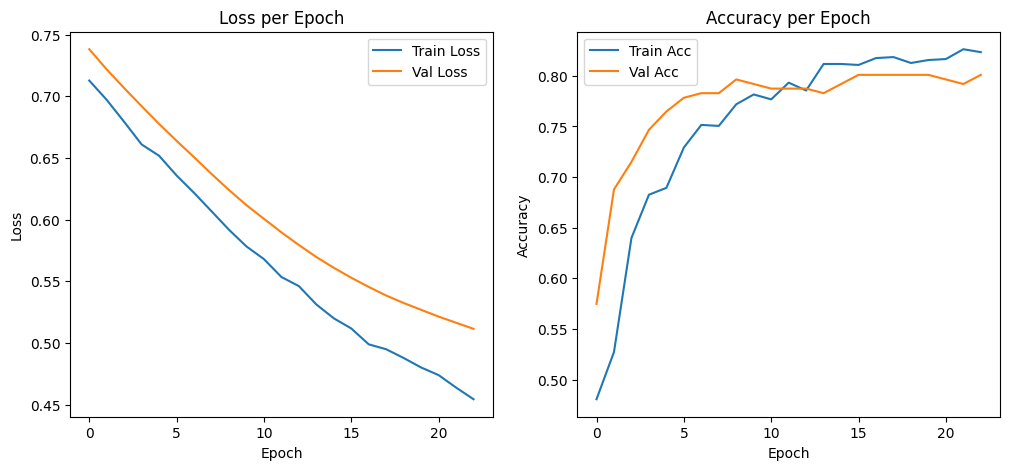

In [76]:
plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch")
plt.legend()

plt.show()


Final Test Accuracy: 0.8281

Classification Report:
              precision    recall  f1-score   support

           0     0.7970    0.9060    0.8480       117
           1     0.8750    0.7404    0.8021       104

    accuracy                         0.8281       221
   macro avg     0.8360    0.8232    0.8250       221
weighted avg     0.8337    0.8281    0.8264       221



<Figure size 600x500 with 0 Axes>

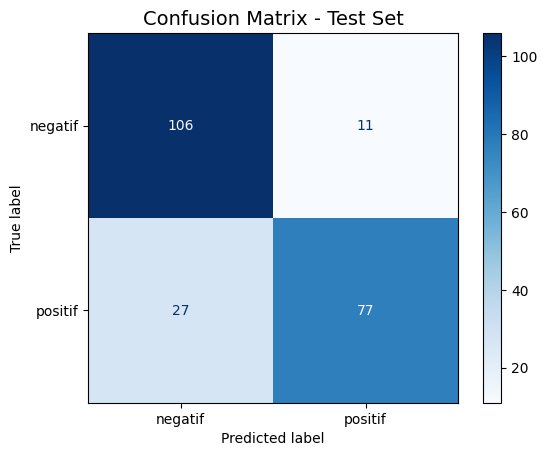

In [77]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ==========================
# Evaluasi di Test Set
# ==========================
model_bert.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for i in range(0, len(X_test_bert), batch_size):
        x_batch = X_test_bert[i:i+batch_size].to(device)
        y_batch = y_test_bert[i:i+batch_size].to(device)

        cls_emb = x_batch[:, 0, :]      # CLS token
        outputs = model_bert(cls_emb)
        preds = torch.max(outputs, 1)[1]

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# ==========================
# Hasil Akhir
# ==========================
test_acc = accuracy_score(all_labels, all_preds)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, digits=4))
# ==========================
# Confusion Matrix
# ==========================
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

plt.figure(figsize=(6, 5))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Test Set", fontsize=14)
plt.show()